# Quick start with AAanalysis
This is a short introduction to **AAanalysis**, a Python framework for sequence-based protein prediction, centered around the **Comparative Physical Profiling (CPP)** algorithm for interpretable feature engineering.

First, import some third-party packages and ``aanalysis``:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import aaanalysis as aa
aa.options["verbose"] = False
aa.options["random_state"] = 42

**Data Loading**

We can load a dataset of amino acid scales using the ``aa.load_scales()`` function. Dataset of protein sequences for a binary classification task, such as our γ-secretase substrates (n=63) and non-substrates (n=63) dataset ([Breimann25a]_), can be retrieved via the ``aa.load_dataest()`` function:

In [2]:
# Load example dataset and scales
df_seq = aa.load_dataset(name="DOM_GSEC")
labels = list(df_seq["label"])
df_scales = aa.load_scales()

**Feature Engineering**

To start feature engineering, we can utilize the ``AAclust`` model for selecting a redundancy-reduced set of amino acid scales:

In [3]:
# Obtain redundancy-reduced set of 100 scales
aac = aa.AAclust()
X = np.array(df_scales).T
scales = aac.fit(X, names=list(df_scales), n_clusters=100).medoid_names_ 
df_scales = df_scales[scales]

We can now use the ``CPP`` algorithm, which aims at identifying a set of features that are most discriminant between two sets of sequences. It´s core idea is the CPP feature concept, defined as a combination of **Parts**, **Splits**, and **Scales**. **Parts** and **Splits** can be obtained using ``SequenceFeature``.

We first create a set of baseline features:

In [4]:
sf = aa.SequenceFeature()

# Obtain Parts and Splits
df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])

Running CPP via ``CPP.run()`` creates all **Part-Split-Scale** combinations and filters them down to a user-defined maximum of non-redundant features (100 by default). As baseline, we use CPP without filtering (`max_cor=1`) to compute the average values for the 100 selected scales over the entire TMD sequences:

In [5]:
# Create 100 baseline features (Scale values averaged over TMD)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, split_kws=split_kws)
df_feat_baseline = cpp.run(labels=labels, max_cor=1)
aa.display_df(df=df_feat_baseline, n_rows=8)

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
1,"TMD-Segment(1,1)-WOLR790101",Polarity,Hydrophobicity (surrounding),Hydration potential,"Hydrophobicity ...n et al., 1979)",0.257000,0.037000,0.037000,0.028000,0.042000,0.000001,0.000064,"11,12,13,14,15,...,26,27,28,29,30"
2,"TMD-Segment(1,1)-FUKS010106",Composition,Membrane proteins (MPs),Proteins of mesophiles (INT),"Interior compos...ishikawa, 2001)",0.240000,0.068000,0.068000,0.065000,0.082000,0.000003,0.000160,"11,12,13,14,15,...,26,27,28,29,30"
3,"TMD-Segment(1,1)-BEGF750103",Conformation,β-turn,β-turn,"Conformational ...in-Dirkx, 1975)",0.237000,0.064000,-0.064000,0.067000,0.087000,0.000004,0.000147,"11,12,13,14,15,...,26,27,28,29,30"
4,"TMD-Segment(1,1)-FASG760105",Polarity,Unclassified (Polarity),pK-C,"pK-C (Fasman, 1976)",0.234000,0.044000,0.044000,0.038000,0.057000,0.000006,0.000142,"11,12,13,14,15,...,26,27,28,29,30"
5,"TMD-Segment(1,1)-YUTK870104",Energy,Free energy (unfolding),Free energy (unfolding),"Activation Gibb...i et al., 1987)",0.234000,0.011000,0.011000,0.010000,0.020000,0.000006,0.000121,"11,12,13,14,15,...,26,27,28,29,30"
6,"TMD-Segment(1,1)-LINS030116",ASA/Volume,Accessible surface area (ASA),ASA (folded β-strand),"Total median ac...s et al., 2003)",0.230000,0.028000,-0.028000,0.021000,0.039000,0.000008,0.000137,"11,12,13,14,15,...,26,27,28,29,30"
7,"TMD-Segment(1,1)-ANDN920101",Structure-Activity,Backbone-dynamics (-CH),α-CH chemical s...kbone-dynamics),"alpha-CH chemic...n et al., 1992)",0.229000,0.068000,-0.068000,0.073000,0.081000,0.000009,0.000131,"11,12,13,14,15,...,26,27,28,29,30"
8,"TMD-Segment(1,1)-ROBB760109",Conformation,β-turn (N-term),β-turn (1st residue),"Information mea...n-Suzuki, 1976)",0.229000,0.039000,-0.039000,0.041000,0.047000,0.000009,0.000115,"11,12,13,14,15,...,26,27,28,29,30"


By default, ``CPP`` creates around 100,000 **Part-Slit** combinations:

In [6]:
# CPP creates around 100,000 features and filters them down to 100
df_parts = sf.get_df_parts(df_seq=df_seq)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts)
df_feat = cpp.run(labels=labels)
aa.display_df(df=df_feat, n_rows=8)

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
1,"TMD_C_JMD_C-Seg...2,3)-QIAN880106",Conformation,α-helix,α-helix (middle),"Weights for alp...ejnowski, 1988)",0.387000,0.118000,0.118000,0.068000,0.080000,0.000000,0.000000,"27,28,29,30,31,32,33"
2,"TMD_C_JMD_C-Pat...,12)-ROBB760109",Conformation,β-turn (N-term),β-turn (1st residue),"Information mea...n-Suzuki, 1976)",0.363000,0.119000,-0.119000,0.065000,0.085000,0.000000,0.000000,"21,25,28,32"
3,"TMD_C_JMD_C-Seg...6,9)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric poi...n et al., 1968)",0.352000,0.268000,0.268000,0.174000,0.173000,0.000000,0.000000,"32,33"
4,"TMD_C_JMD_C-Seg...4,9)-ROBB760113",Conformation,β-turn,β-turn,"Information mea...n-Suzuki, 1976)",0.349000,0.337000,-0.337000,0.177000,0.254000,0.000000,0.000000,"27,28"
5,"TMD_C_JMD_C-Seg...4,5)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric poi...n et al., 1968)",0.336000,0.205000,0.205000,0.134000,0.157000,0.000000,0.000000,"33,34,35,36"
6,"TMD_C_JMD_C-Pat...,15)-QIAN880106",Conformation,α-helix,α-helix (middle),"Weights for alp...ejnowski, 1988)",0.336000,0.152000,0.152000,0.102000,0.132000,0.000000,0.000000,"28,32,35"
7,"TMD_C_JMD_C-Seg...6,9)-LINS030101",ASA/Volume,Volume,Accessible surface area (ASA),"Total accessibl...s et al., 2003)",0.328000,0.235000,0.235000,0.156000,0.187000,0.000000,0.000000,"32,33"
8,"TMD_C_JMD_C-Seg...2,3)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric poi...n et al., 1968)",0.326000,0.108000,0.108000,0.077000,0.085000,0.000000,0.000000,"27,28,29,30,31,32,33"



**Machine Learning (Protein Prediction)**

A feature matrix for a given set of CPP features can be created using the ``SequenceFeature.feature_matrix()`` method. The feature matrix will be used to train a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model:

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create feature matrix and perform prediction for baseline features
X = sf.feature_matrix(df_parts=df_parts, features=df_feat_baseline["feature"])
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, labels, scoring="accuracy", cv=5)
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.62


We create now the feature matrix for the features obtained with CPP default settings:

In [8]:
# Create feature matrix and perform prediction for default CPP features
X = sf.feature_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, labels, scoring="accuracy", cv=5) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")


Mean accuracy of 0.87


We can compare the baseline and default CPP feature set using a bar chart:

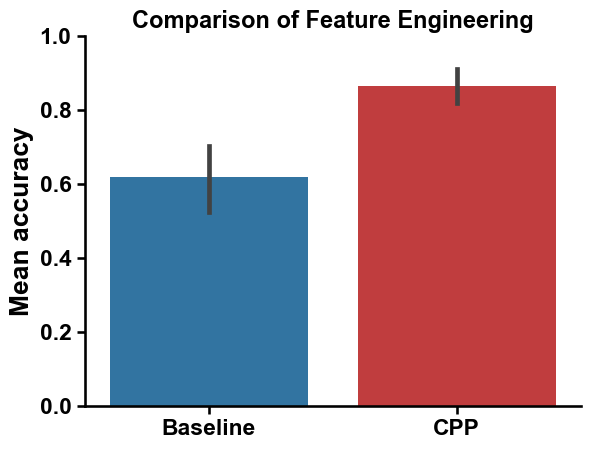

In [9]:
# Comparison of baseline and default CPP feature sets
aa.plot_settings()
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
plt.ylim(0, 1)
plt.title("Comparison of Feature Engineering", size=aa.plot_gcfs()-1)
sns.despine()
plt.show()

**CPP Analysis (group level)**

AAanalysis offers various plotting functions for interpreting the CPP features at group and sample level by ``CPPPlot``. We first need to include the group-level feature importance using the ``TreeModel`` and its ``TreeModel.add_feat_importance()`` method:

In [10]:
# Include group level feature importance
tm = aa.TreeModel()
tm.fit(X, labels=labels)
df_feat = tm.add_feat_importance(df_feat=df_feat)

The top15 features can be displayed using the ``CPPPlot.ranking()`` method:


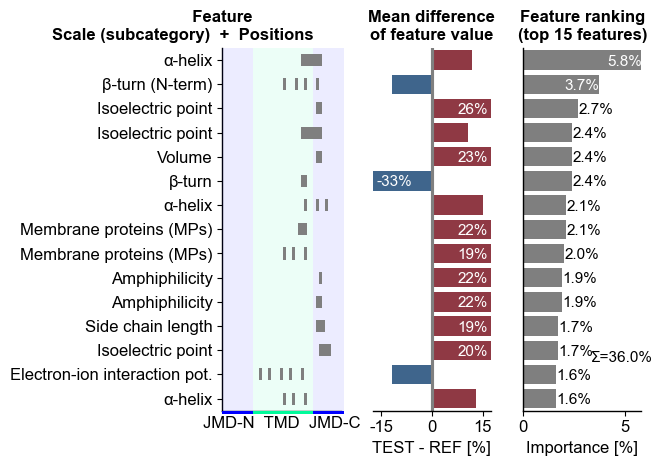

In [11]:
# Plot CPP ranking
cpp_plot = aa.CPPPlot()
aa.plot_settings(short_ticks=True, weight_bold=False)
cpp_plot.ranking(df_feat=df_feat)
plt.tight_layout()
plt.show()

The distributions of features values for the highest-ranked feature can be displayed using the ``CPPPlot.feature()`` method:

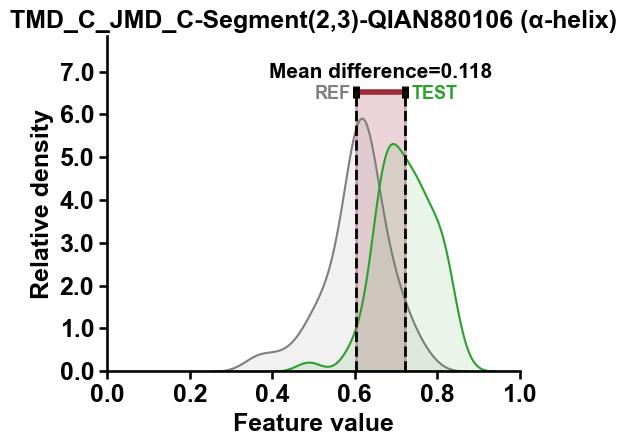

In [12]:
top_feature = df_feat["feature"][0]
top_subcategory = df_feat["subcategory"][0]
aa.plot_settings()
cpp_plot.feature(feature=top_feature , df_seq=df_seq, labels=labels)
plt.title(f"{top_feature} ({top_subcategory})")
plt.tight_layout()
plt.show()

The cumulative feature importance per residue position can be visualized by the ``CPPPlot.profile()`` method:

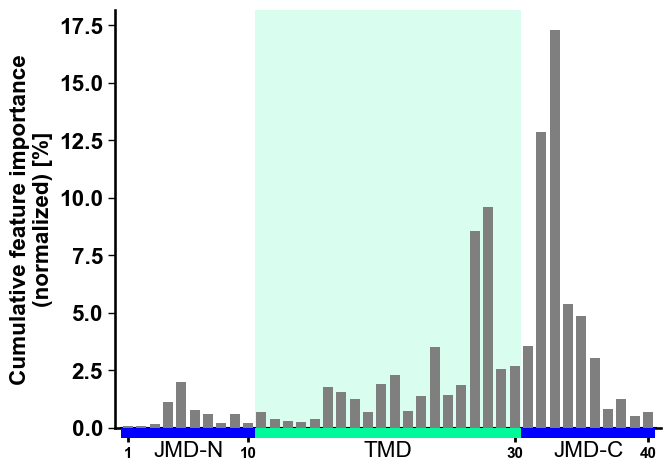

In [13]:
# Plot CPP profile
aa.plot_settings(font_scale=0.9)
cpp_plot.profile(df_feat=df_feat)
plt.tight_layout()
plt.show()

 To uncover the common physicochemical signature discriminating the test from the reference protein set, use the ``CPPPlot.feature_map()`` method showing the feature value differences per scale subcategory at single-residue resolution:

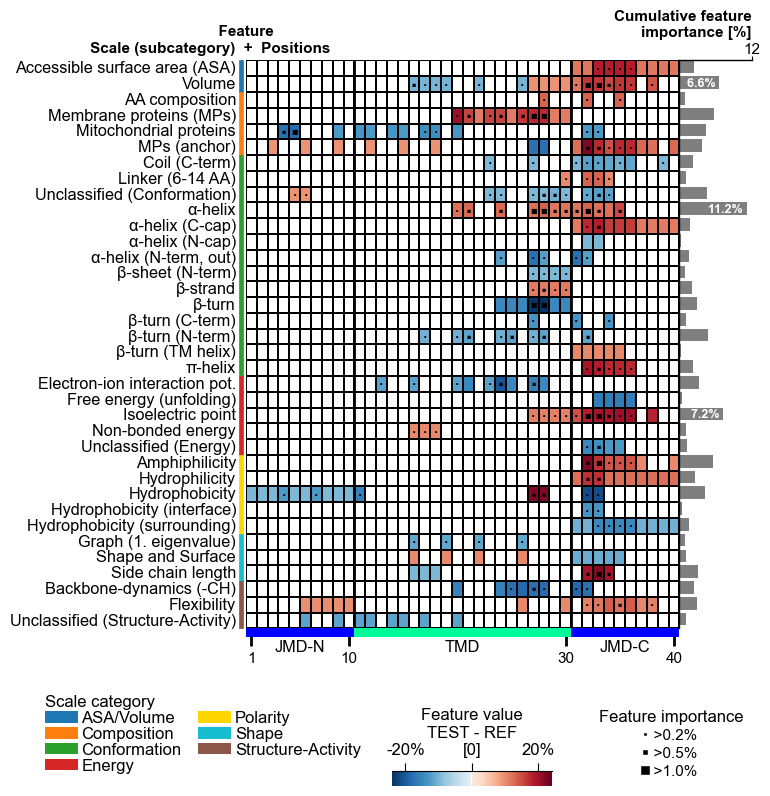

In [21]:
# Plot CPP feature map (original version: without importance bars on top)
cpp_plot = aa.CPPPlot()
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.feature_map(df_feat=df_feat, add_imp_bar_top=False)
plt.show()

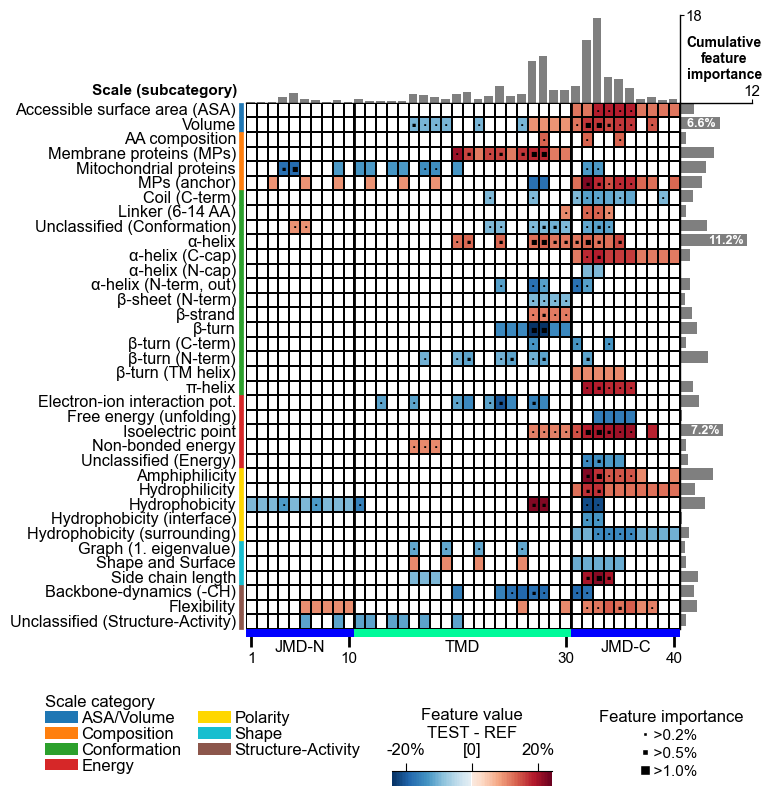

In [22]:
# Plot CPP feature map (v1.0.2+: with importance bars on top)
cpp_plot = aa.CPPPlot()
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.feature_map(df_feat=df_feat)
plt.show()

**CPP-SHAP Analysis (sample level)**

We can analyse the impact of features on the prediction score for individual sequence using the ``ShapExplainer`` model, which combines ``CPP`` with the explainable AI framework [SHAP](https://shap.readthedocs.io/en/latest/index.html).

In [15]:
# Obtain sample-specific feature impact
sm = aa.ShapModel()
sm.fit(X, labels=labels)
df_feat = sm.add_feat_impact(df_feat=df_feat)
df_feat = sm.add_sample_mean_dif(X, labels=labels, df_feat=df_feat)

We can now show the feature ranking for a selected protein ('Protein0') using the ``CPPPlot.ranking()`` method, plotting SHAP analysis results by setting ``shap_plot=True``:

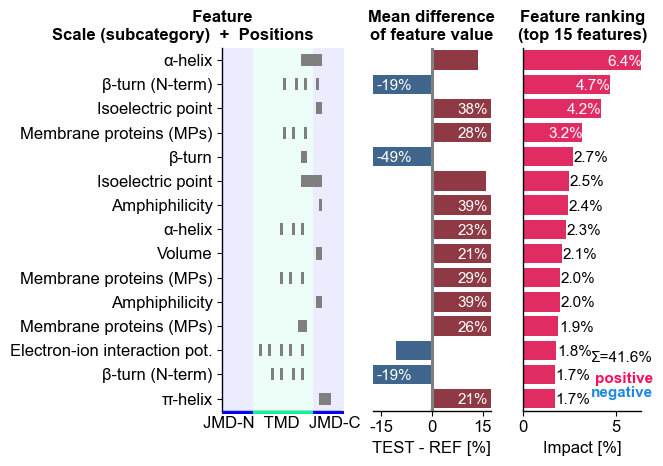

In [16]:
# CPP-SHAP ranking plot
aa.plot_settings(short_ticks=True, weight_bold=False)
cpp_plot.ranking(df_feat=df_feat, shap_plot=True, col_dif="mean_dif_Protein0", col_imp="feat_impact_Protein0")
plt.tight_layout()
plt.show()

To visualize the CPP-SHAP profile and heatmap, we need to obtain the sequence parts of the respective protein:

In [17]:
# Get sequences parts for APP
_df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd", "jmd_c", "jmd_n"])
_args_seq = _df_parts.loc["P05067"].to_dict()
args_seq = {key + "_seq": _args_seq[key] for key in _args_seq}

Show the specific **CPP-SHAP Profile** for the first Protein using the ``CPPPlot.profile()`` method with setting ``shap_plot=True``:

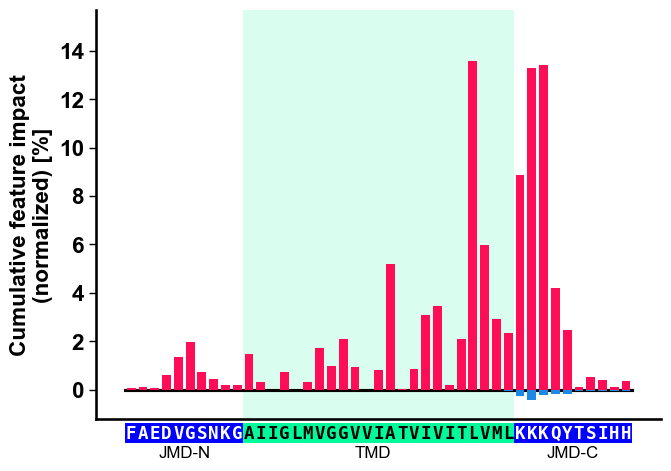

In [18]:
# CPP-SHAP profile
aa.plot_settings(font_scale=0.9)
cpp_plot.profile(df_feat=df_feat, shap_plot=True, col_imp="feat_impact_Protein0", **args_seq)
plt.tight_layout()
plt.show()

With the ``CPPPlot.heatmap()`` we can visualize the sample-specific feature value difference and the feature impact per scale subcategory and residue position:   

/tmp/ipykernel_28557/438124917.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


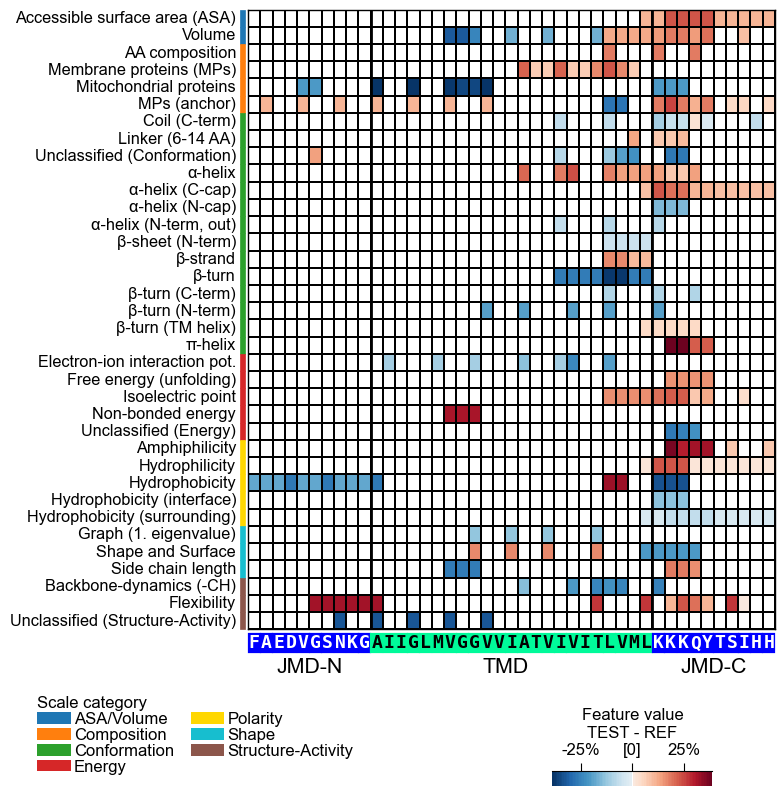

/tmp/ipykernel_28557/438124917.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


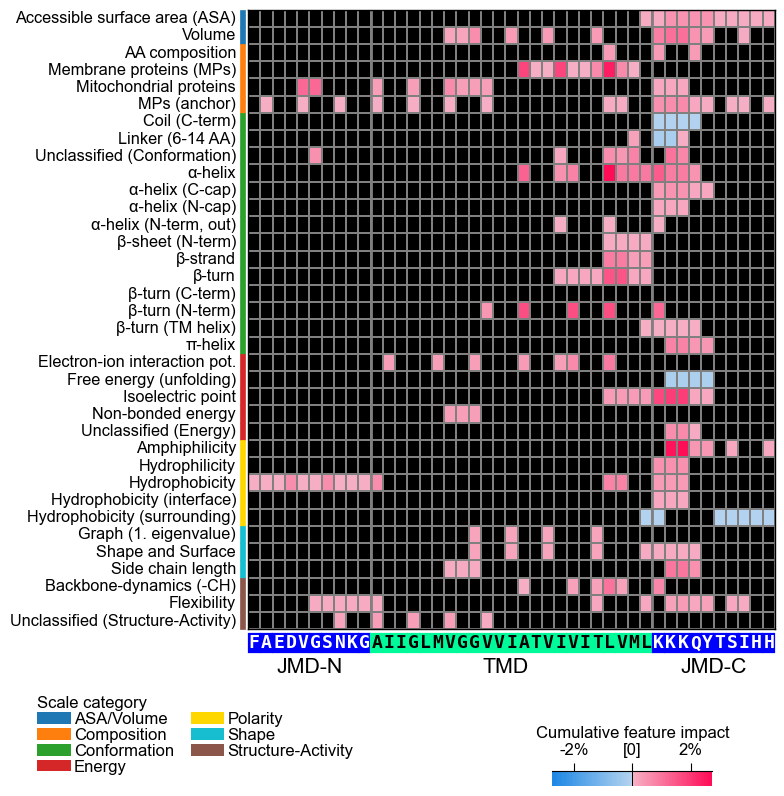

In [19]:
# CPP heatmap (sample level)
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.heatmap(df_feat=df_feat, shap_plot=True, col_val="mean_dif_Protein0", **args_seq)
plt.tight_layout()
plt.show()

# CPP-SHAP heatmap (sample level)
cpp_plot.heatmap(df_feat=df_feat, shap_plot=True, col_val="feat_impact_Protein0", **args_seq)
plt.tight_layout()
plt.show()

See our [Feature Engineering API](https://aaanalysis.readthedocs.io/en/latest/api.html#feature-engineering) for a comprehensive documentation on the ``CPP``, ``CPPPlot``, ``AAclust``, and ``SequenceFeature`` classes.